# Bayesian PINN (BPINN) for Uncertainty Quantification

### 1. Introduction: Beyond Point Predictions

Standard (deterministic) PINNs provide a single point prediction for the solution of a PDE. However, in many scientific and engineering applications, it's crucial to know how confident the model is in its predictions. This is where **Uncertainty Quantification (UQ)** comes in.

The **Bayesian Physics-Informed Neural Network (BPINN)** is a framework that incorporates Bayesian inference into the PINN model. Instead of learning a single set of weights, a BPINN learns a *distribution* over the network weights. This allows it to output not just a mean prediction but also a measure of uncertainty (typically the variance or standard deviation).

This uncertainty can arise from two main sources:
-   **Aleatoric uncertainty:** Inherent randomness or noise in the data.
-   **Epistemic uncertainty:** Uncertainty due to the model's lack of knowledge, often higher in regions with sparse training data.

### 2. Demonstration: 1D Poisson Equation with `PFNN`

This notebook demonstrates a practical way to implement a BPINN using DeepXDE's built-in **Probabilistic Feed-forward Neural Network (`dde.nn.PFNN`)**. This network architecture is designed to output two values for each input point:
1.  The **mean** ($\mu$) of the predicted solution.
2.  The **log-variance** ($\log(\sigma^2)$) of the predicted solution.

We will solve a simple 1D Poisson equation and use the `PFNN`'s outputs to visualize the mean prediction along with its confidence interval (uncertainty bounds).

**Problem Definition:**
-   **PDE:** $-u_{xx}(x) = \pi^2 \sin(\pi x)$
-   **Domain:** $x \in [-1, 1]$
-   **Boundary Conditions:** $u(-1) = 0, u(1) = 0$
-   **Analytical Solution:** $u(x) = \sin(\pi x)$


In [10]:
import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set backend to PyTorch for this example if needed
# dde.config.set_default_backend("pytorch")


### Step 1: Define the PDE, Geometry, and BCs

First, we define the PDE residual function. A key aspect of this BPINN implementation is that the physics-informed loss is only applied to the **mean** of the network's probabilistic output. The network's second output (the variance) is constrained by the data likelihood during training, not directly by the PDE.

The boundary conditions are also applied only to the mean prediction. We specify `component=0` in the `DirichletBC` to ensure this.


In [11]:
# 1. Define the PDE and analytical solution
def pde_func(x, y):
    """Standard strong-form PDE residual for -u_xx = f(x)"""
    # y has two components: y[:, 0:1] is the mean, y[:, 1:2] is the log(variance)
    u_mean = y[:, 0:1]
    
    # We only apply the PDE to the mean of the prediction
    du_xx = dde.grad.hessian(u_mean, x, i=0, j=0)
    
    # Use torch functions for GPU compatibility and consistency with the backend
    source_term = torch.pi**2 * torch.sin(torch.pi * x)
    
    return -du_xx - source_term

def analytical_solution(x):
    # This is used for testing, so it operates on NumPy arrays
    return np.sin(np.pi * x)

# 2. Define Geometry and Boundary Conditions
geom = dde.geometry.Interval(-1, 1)

# The boundary condition is applied to the mean of the prediction (component=0)
bc = dde.DirichletBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary, component=0)


### Step 2: Define and Train the BPINN Model

Now, we define the BPINN model using `dde.nn.PFNN`. The network will have 1 input neuron (`x`) and 2 output neurons (mean and log-variance).

When we compile the model, we don't need to specify a custom loss. DeepXDE automatically recognizes that `PFNN` is a probabilistic network and uses the appropriate loss function, which is the **negative log-likelihood**. This loss naturally encourages the network to produce a smaller variance where the mean prediction is accurate and a larger variance where it is less certain.


In [12]:
# 3. Define the BPINN Model using a Probabilistic FNN
# It has 2 outputs: mean and log(variance)
net = dde.nn.PFNN([1] + [20] * 3 + [2], "tanh", "Glorot normal")

# 4. Define the Data object
data = dde.data.PDE(
    geom,
    pde_func,
    bc,
    num_domain=20,
    num_boundary=2,
    solution=analytical_solution,
    num_test=100,
)

# 5. Compile and Train the Model
model = dde.Model(data, net)
# The default loss for a probabilistic network in DeepXDE is the negative log-likelihood
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)


Compiling model...
'compile' took 0.000307 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.82e+01, 5.54e-02]    [5.01e+01, 5.54e-02]    []  


1000      [2.90e-04, 4.16e-07]    [3.13e-04, 4.16e-07]    []  
2000      [1.69e-04, 2.54e-07]    [1.84e-04, 2.54e-07]    []  
3000      [1.21e-04, 2.85e-07]    [1.42e-04, 2.85e-07]    []  
4000      [6.78e-05, 1.79e-07]    [9.18e-05, 1.79e-07]    []  
5000      [4.13e-05, 8.99e-09]    [6.83e-05, 8.99e-09]    []  
6000      [2.91e-05, 8.33e-08]    [5.09e-05, 8.33e-08]    []  
7000      [1.77e-05, 1.41e-08]    [4.54e-05, 1.41e-08]    []  
8000      [1.27e-05, 5.25e-09]    [3.66e-05, 5.25e-09]    []  
9000      [1.04e-05, 3.18e-08]    [3.64e-05, 3.18e-08]    []  
10000     [7.98e-06, 1.52e-08]    [2.84e-05, 1.52e-08]    []  
11000     [5.58e-06, 1.03e-11]    [2.60e-05, 1.03e-11]    []  
12000     [4.48e-06, 7.47e-10]    [2.32e-05, 7.47e-10]    []  
13000     [2.05e-05, 5.21e-07]    [2.75e-05, 5.21e-07]    []  
14000     [3.29e-05, 8.55e-07]    [3.54e-05, 8.55e-07]    []  
15000     [4.97e-06, 7.53e-08]    [2.49e-05, 7.53e-08]    []  
16000     [2.14e-06, 1.33e-09]    [1.88e-05, 1.33e-09] 

### Step 3: Uncertainty Quantification and Visualization

After training, the model can predict both the mean and the log-variance for any given input point `x`. To visualize the uncertainty, we perform the following steps:

1.  Predict on a dense set of test points to get the `mean` and `log_variance` outputs.
2.  Calculate the standard deviation ($\sigma$) from the log-variance using the formula: $\sigma = \sqrt{e^{\log(\sigma^2)}}$.
3.  Plot the analytical solution and the BPINN's mean prediction.
4.  Use `plt.fill_between` to draw a shaded region around the mean prediction. This region typically represents a confidence interval, such as $\mu \pm 2\sigma$ (which corresponds to a ~95% confidence interval for a Gaussian distribution).

This plot provides a powerful visual summary: not only how well the model's average prediction matches the true solution, but also in which areas the model is more or less confident.


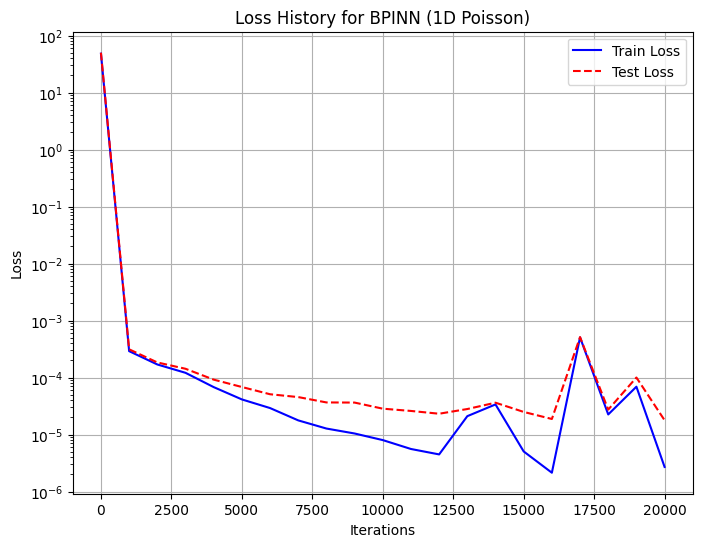

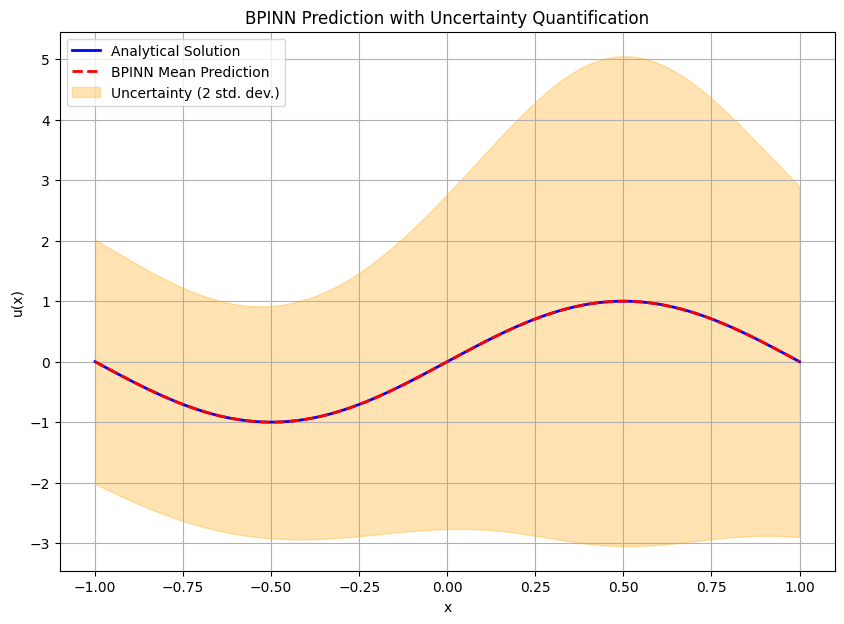

L2 relative error on mean: 2.6053e-04


In [13]:
# 6. Plotting and Results
# Manually plot the loss history
loss_train = np.sum(np.array(losshistory.loss_train), axis=1)
loss_test = np.sum(np.array(losshistory.loss_test), axis=1)

plt.figure(figsize=(8, 6))
plt.plot(losshistory.steps, loss_train, 'b-', label='Train Loss')
plt.plot(losshistory.steps, loss_test, 'r--', label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss History for BPINN (1D Poisson)')
plt.legend()
plt.grid(True)
plt.show()

# 7. Uncertainty Quantification and Visualization
X_test = geom.uniform_points(200, True)
y_pred = model.predict(X_test)
y_true = analytical_solution(X_test)

mean_pred = y_pred[:, 0]
log_var_pred = y_pred[:, 1]
std_dev_pred = np.sqrt(np.exp(log_var_pred))

plt.figure(figsize=(10, 7))
plt.plot(X_test, y_true, 'b-', label='Analytical Solution', linewidth=2)
plt.plot(X_test, mean_pred, 'r--', label='BPINN Mean Prediction', linewidth=2)

# Plot the uncertainty region (e.g., 2 standard deviations)
plt.fill_between(
    X_test.flatten(), 
    mean_pred - 2 * std_dev_pred, 
    mean_pred + 2 * std_dev_pred, 
    color='orange', 
    alpha=0.3, 
    label='Uncertainty (2 std. dev.)'
)

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('BPINN Prediction with Uncertainty Quantification')
plt.legend()
plt.grid(True)
plt.show()

# Report L2 relative error on the mean prediction
l2_error = dde.metrics.l2_relative_error(y_true, mean_pred.reshape(-1, 1))
print(f"L2 relative error on mean: {l2_error:.4e}")
